In [58]:
import sys
import torch

In [ ]:
import torch
torch.cuda.empty_cache()

In [59]:
sys.path.append('../')

In [60]:
from vt_captioning.vt_resnet import vt_resnet50

In [61]:
feature_extractor = vt_resnet50(
            pretrained=True,
            freeze='full_freeze', # only freezes resnet
            tokens=16,
            token_channels=128,
            input_dim=1024,
            vt_channels=2048,
            transformer_enc_layers=2,
            transformer_heads=8,
            transformer_fc_dim=2048,
            image_channels=3,
        )
    
feature_extractor.to("cuda")

VTResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [62]:
from transformers import AutoTokenizer

In [63]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [64]:
VOCAB_SIZE = len(tokenizer)

In [65]:
print(VOCAB_SIZE)

30522


In [66]:
from transformer_code.vt_captioning import VTCaptionModel

In [67]:
model = VTCaptionModel(feature_extractor, num_layers = 8, d_model = 1024, num_heads = 16, dff = 2048, row_size = 1, col_size = 1, target_vocab_size = VOCAB_SIZE, max_pos_encoding=VOCAB_SIZE, rate=0.2)
model.to("cuda")

VTCaptionModel(
  (VT): VTResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [68]:
model.load_state_dict(torch.load('VTResCaptioner.pt'))

<All keys matched successfully>

In [69]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+----------------------------------------------------------+------------+
|                         Modules                          | Parameters |
+----------------------------------------------------------+------------+
|                   VT.resnet.fc.weight                    |  2048000   |
|                    VT.resnet.fc.bias                     |    1000    |
|                       VT.bn.weight                       |    1024    |
|                        VT.bn.bias                        |    1024    |
|         VT.vt_layers.0.tokenizer.linear1.weight          |   16384    |
|          VT.vt_layers.0.tokenizer.linear1.bias           |     16     |
|         VT.vt_layers.0.tokenizer.linear2.weight          |   131072   |
|          VT.vt_layers.0.tokenizer.linear2.bias           |    128     |
| VT.vt_layers.0.transformer.attention.query_linear.weight |   16384    |
|  VT.vt_layers.0.transformer.attention.key_linear.weight  |   16384    |
|        VT.vt_layers.0.transformer.li

73250458

In [70]:
import pandas as pd


In [71]:
dataset = pd.read_csv('../captioning_coco/cocoval.csv')

In [72]:
from PIL import Image

In [73]:
import torchvision

In [74]:
transform = torchvision.transforms.Compose([
     torchvision.transforms.Resize((300, 300)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

In [75]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [83]:
from transformer_code.mha import create_look_ahead_mask, create_padding_mask

device = "cuda"

def create_masks_decoder(tar):
    look_ahead_mask = create_look_ahead_mask(tar.size(1)).to(device)
    dec_target_padding_mask = create_padding_mask(tar).to(device)

    combined_mask = torch.max(dec_target_padding_mask, look_ahead_mask)
    return combined_mask

In [85]:
import torch

def evaluate(image):

    input = transform(image).unsqueeze(0).to("cuda") 

    decoder_input = ["[CLS]"] + ["[PAD]"] * 19
    
    decoder_input = tokenizer(decoder_input, add_special_tokens = False, return_tensors="pt")["input_ids"].to("cuda").permute(1,0)

    result = []  # Word list

    for i in range(20):
        with torch.no_grad():
            dec_mask = create_masks_decoder(decoder_input).to("cuda")
            predictions, _ = model(input, decoder_input, dec_mask)

            predicted_id = torch.argmax(predictions.permute(0,2,1), dim=-1)[0][i].item()
            
            if tokenizer.decode(predicted_id) == "[SEP]" or tokenizer.decode(predicted_id) == "[PAD]":
                return result

            result.append(tokenizer.decode(predicted_id))
        
            decoder_input[0, i+1] = predicted_id

    return result

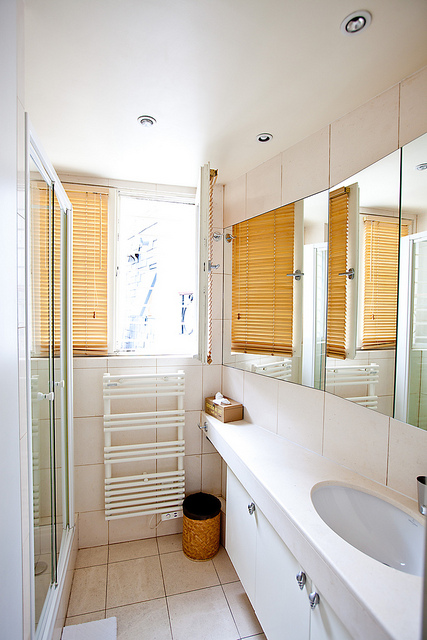

In [86]:
Image.open(dataset.path[10040])

In [87]:
dataset["captions"][10040]

'image of a vanity shower and open window in a bathroom'

In [89]:
evaluate(Image.open(dataset.path[10040]))

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.80 GiB. GPU 0 has a total capacty of 8.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 12.81 GiB is allocated by PyTorch, and 549.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [31]:
" ".join(_)

'a wooden table ##cloth'

In [22]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
bleu_scores = {"bleu1: ": [], "bleu2" : [], "bleu3" : [], "bleu4" : []}    

for x in range(100):
    image = Image.open("../" + dataset["image_file"][x])

    score1 = sentence_bleu([dataset["captions"][x].split()], evaluate(image), weights=(1.0, 0, 0, 0))
    score2 = sentence_bleu([dataset["captions"][x].split()], evaluate(image), weights=(0.5, 0.5, 0, 0))
    score3 = sentence_bleu([dataset["captions"][x].split()], evaluate(image), weights=(0.33, 0.33, 0, 0))
    score4 = sentence_bleu([dataset["captions"][x].split()], evaluate(image), weights=(0.25, 0.25, 0.25, 0.25))
    
    bleu_scores["bleu1"].append(score1)
    bleu_scores["blue2"].append(score2)
    bleu_scores["blue3"].append(score3)
    bleu_scores["blue4"].append(score4)


In [ ]:
import json

In [ ]:
with open('bleu_scores.json', 'w') as fp:
    json.dump(bleu_scores, fp)